# Проект: Линейные модели в машинном обучении

### Описание проекта
Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!
Поэтому нужно разработать модель машинного обучения, которая поможет управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. 

## Загрузка данных

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install imblearn -q

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import (
    recall_score, r2_score, 
    confusion_matrix,
    mean_absolute_error, 
    mean_squared_error, 
    precision_score, 
    accuracy_score
)

In [3]:
try:
    ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal = ',')
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal = ',')
    cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal = ',')
except:
    ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';', decimal = ',')
    ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';', decimal = ',')
    cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';', decimal = ',')

##  Предобработка данных

In [4]:
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [5]:
ferma_main.rename(columns = {'Удой, кг':'удой',
                       'Сырой протеин, г':'сырой протеин',
                       'Жирность,%':'жирность',
                       'Белок,%':'белок',
                       'СПО (Сахаро-протеиновое соотношение)':'спо',
                       'ЭКЕ (Энергетическая кормовая единица)':'эке'},
            inplace = True )

In [6]:
ferma_main.columns = ferma_main.columns.str.replace(' ', '_')
ferma_main.columns = ferma_main.columns.str.lower()

In [7]:
ferma_main['сырой_протеин'] = ferma_main['сырой_протеин'] / 1000

In [8]:
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].str.lower()

In [9]:
for i in ['эке', 'спо', 'жирность', 'белок']:
    ferma_main[i] = ferma_main[i].astype('float')

ferma_main.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1.743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2.138,0.890,Вис Бик Айдиал,равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1.854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2.012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1.675,0.885,Вис Бик Айдиал,равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [10]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                634 non-null    int64  
 1   удой              634 non-null    int64  
 2   эке               634 non-null    float64
 3   сырой_протеин     634 non-null    float64
 4   спо               634 non-null    float64
 5   порода            634 non-null    object 
 6   тип_пастбища      634 non-null    object 
 7   порода_папы_быка  634 non-null    object 
 8   жирность          634 non-null    float64
 9   белок             634 non-null    float64
 10  вкус_молока       634 non-null    object 
 11  возраст           634 non-null    object 
dtypes: float64(5), int64(2), object(5)
memory usage: 59.6+ KB


In [11]:
ferma_main.duplicated().sum()

5

In [12]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop = True)
ferma_main.duplicated().sum()

0

In [13]:
ferma_main['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [14]:
ferma_main['порода_папы_быка'] = ferma_main['порода_папы_быка'].str.replace('Айдиалл','Айдиал')
ferma_main['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [15]:
ferma_main['порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [16]:
ferma_main['тип_пастбища'].unique()

array(['равнинное', 'равнинные', 'холмистое'], dtype=object)

In [17]:
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].str.replace('равнинные','равнинное')
ferma_main['тип_пастбища'].unique()

array(['равнинное', 'холмистое'], dtype=object)

Изучил данные первой таблицы **ferma_main**, привел название столбцов в нормальный вид, данные столбца **сырой_протеин** поменял г на кг, согласно системе СИ, поменял формат данных на вещественный и запятые заменил на точки в столбцах **эке**, **спо**, **жирность** и  **белок**, убрал 5 дубликатов в таблице, в столбцах **порода_папы_быка** и **тип_пастбища** убрал дублирующие значения с разным написанием и перевел в нижний регистр.

In [18]:
ferma_dad.head(10)

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


In [19]:
ferma_dad.rename(columns = {'Имя Папы':'имя_папы'}, inplace = True )

In [20]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [21]:
ferma_dad['имя_папы'].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

In [22]:
ferma_dad.duplicated().sum()

0

Изучил данные первой таблицы **ferma_dad**, привел название столбца в нормальный вид, проверил данные на дубликаты, на уникальные значения и посмотрел общую информацию по данным талицы.

In [23]:
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [24]:
cow_buy.rename(columns = {'Текущая_жирность,%':'жирность',
                       'Текущий_уровень_белок,%':'белок'},
            inplace = True )

In [25]:
cow_buy.columns = cow_buy.columns.str.replace(' ', '_')
cow_buy.columns = cow_buy.columns.str.lower()

In [26]:
cow_buy.duplicated().sum()

4

In [27]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   порода            20 non-null     object 
 1   тип_пастбища      20 non-null     object 
 2   порода_папы_быка  20 non-null     object 
 3   имя_папы          20 non-null     object 
 4   жирность          20 non-null     float64
 5   белок             20 non-null     float64
 6   возраст           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [28]:
for i in ['жирность', 'белок']:
    cow_buy[i] = cow_buy[i].astype('float')
cow_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [29]:
cow_buy['тип_пастбища'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [30]:
cow_buy['имя_папы'].unique()

array(['Геркулес', 'Буйный', 'Барин', 'Соловчик'], dtype=object)

In [31]:
cow_buy['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [32]:
cow_buy['порода'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

Изучил данные первой таблицы **cow_buy**, привел название столбцов в нормальный вид, обнаружил 4 дубликата,так как таблица не больщая и отсутствуют более обширные данные,предположил что скорее всего это не дубликаты,а повторяющиеся значения разных коров, в столбцах **жирность** и **белок** поменял тип данных на вещественный и заменил запятую на точку, проверил уникальные значения в стобцах, отклонений не обнаружил.

## Исследовательский анализ данных

In [33]:
ferma_main.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,629.0,NaN,NaN,NaN,315.0,181.72094,1.0,158.0,315.0,472.0,629.0
удой,629.0,NaN,NaN,NaN,6188.750397,1644.795489,5204.0,5751.0,6133.0,6501.0,45616.0
эке,629.0,NaN,NaN,NaN,14.543879,1.306408,10.9,13.5,14.7,15.6,16.8
сырой_протеин,629.0,NaN,NaN,NaN,1.923364,0.182956,1.66,1.771,1.888,2.062,2.349
спо,629.0,NaN,NaN,NaN,0.913116,0.032203,0.84,0.89,0.93,0.94,0.96
порода,629,2,Вис Бик Айдиал,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
тип_пастбища,629,2,холмистое,351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
порода_папы_быка,629,2,Айдиал,318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
жирность,629.0,NaN,NaN,NaN,3.603657,0.168656,2.99,3.59,3.65,3.72,3.75
белок,629.0,NaN,NaN,NaN,3.075671,0.002549,3.069,3.074,3.076,3.077,3.085


Постмотрел основные статистические характеристики данных по каждому признаку таблицы, сразу заметил явный выброс в столбце **удой**, в остальных данных таблицы пока без замечаний.

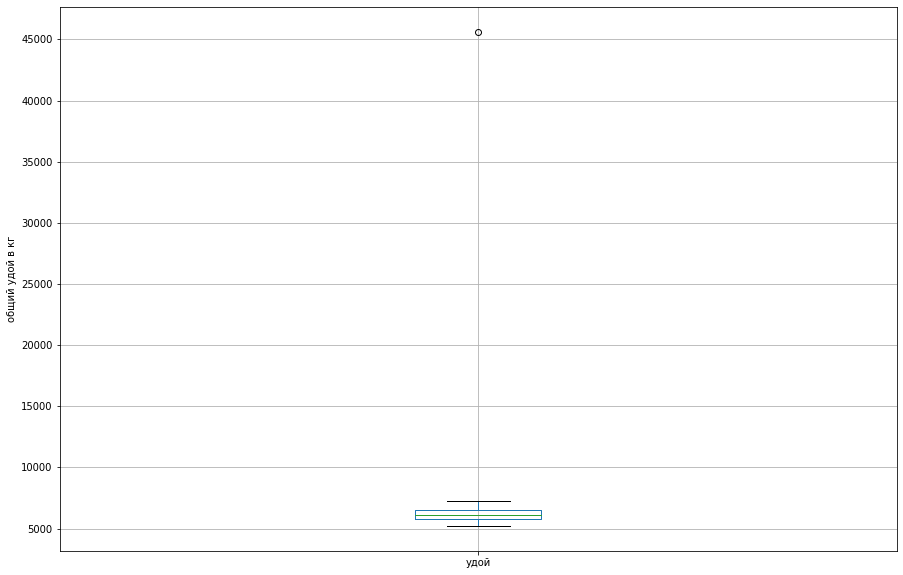

In [34]:
ferma_main.boxplot(column=['удой'], figsize=(15,10), grid=True)
plt.ylabel('общий удой в кг')
plt.show()

In [35]:
ferma_main.loc[ferma_main['удой'] >= 10000, 'удой'] = ferma_main['удой'].mean()

Заменил выброс в столбце **удой** 50 процентилем что бы не терять данные,оставим эту строку.

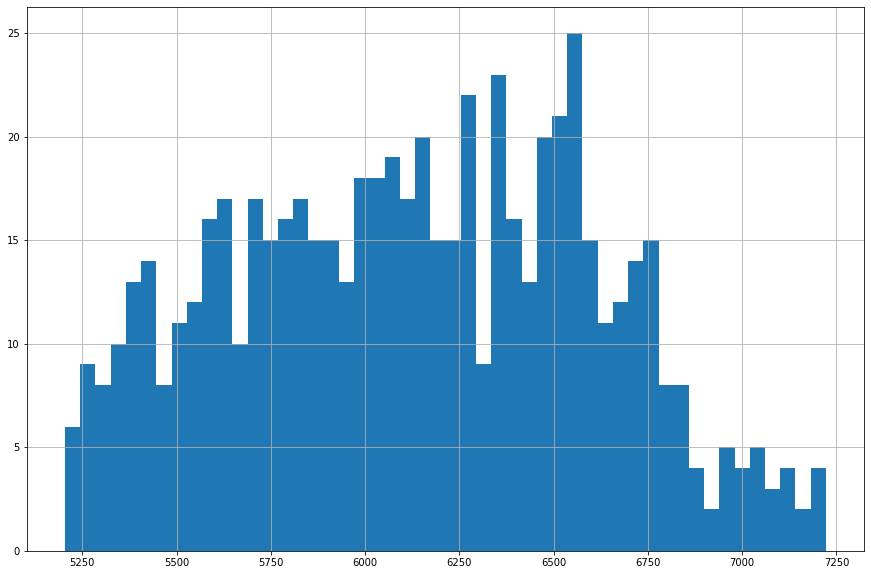

In [36]:
ferma_main.удой.hist(bins = 50, figsize = (15,10));

В среднем пики массы молока в таблице **удой** идут от 6100кг до 6600кг.

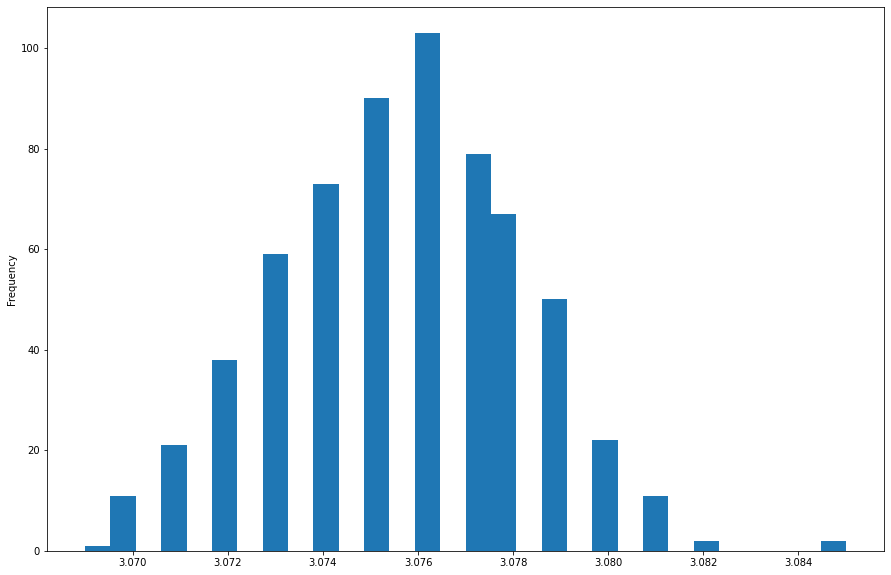

In [37]:
ferma_main['белок'].plot(kind ='hist', bins=30, figsize=(15,10));

Пики содержания белка в молоке в таблице **белок**, находятся около среднего значения(3,076).

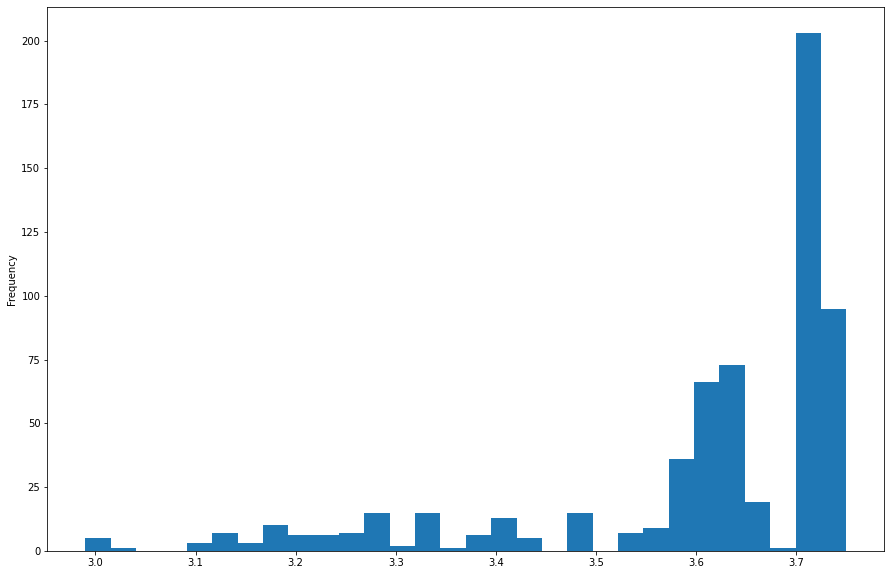

In [38]:
ferma_main['жирность'].plot(kind ='hist', bins=30, figsize=(15,10));

Большое количество коров дают высокую жирность молока, это нам говорит что данные в этом столбце распределены НЕнормально.

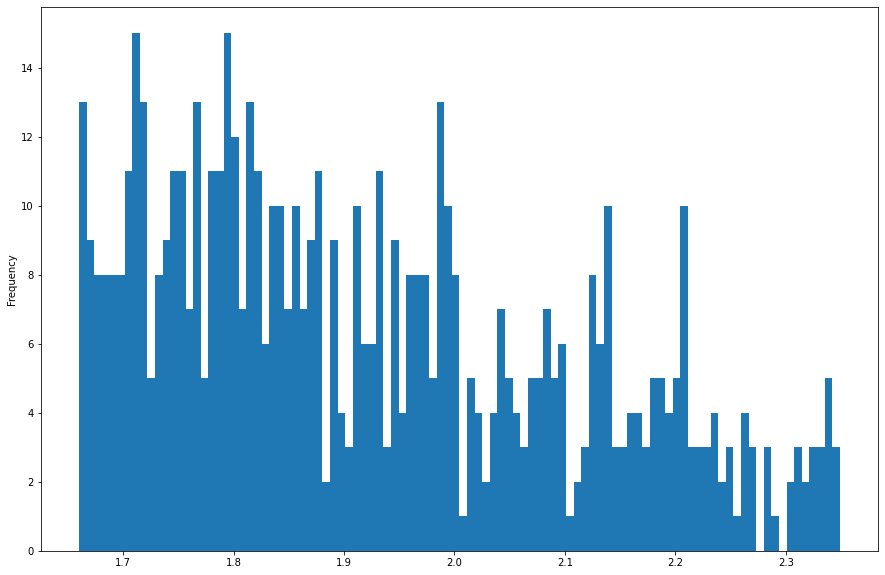

In [39]:
ferma_main['сырой_протеин'].plot(kind ='hist', bins=100, figsize=(15,10));

Содержание сырого протеина в корме находится в диапазоне от 1,6 до 2,3, здесь тоже можно сказать о НЕнормально распределении.

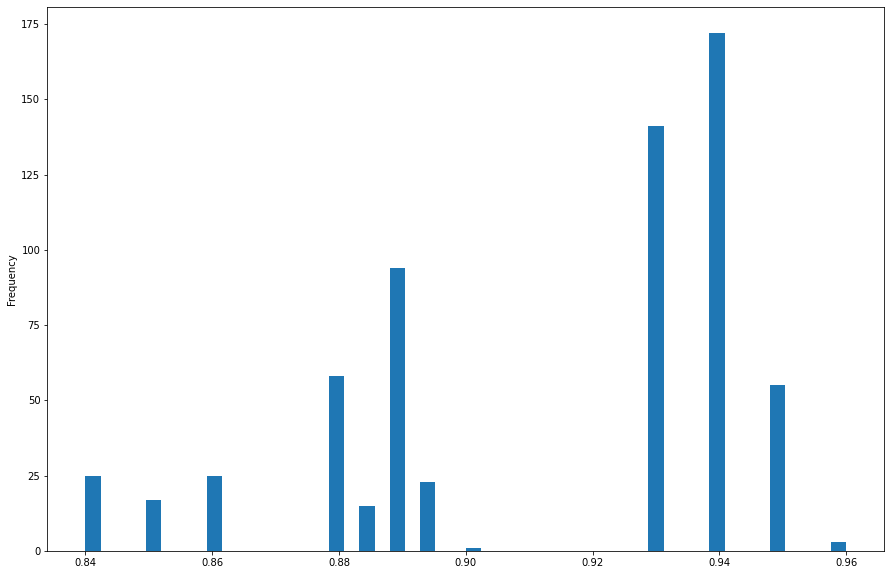

In [40]:
ferma_main['спо'].plot(kind ='hist', bins=50, figsize=(15,10));

Отношение сахара к протеину в корме коровы находится в диапазоне от 0,84 до 0,96 и заметно условное деление данных до 0,9 и более 0,91, здесь так же данные распределены НЕнормально.

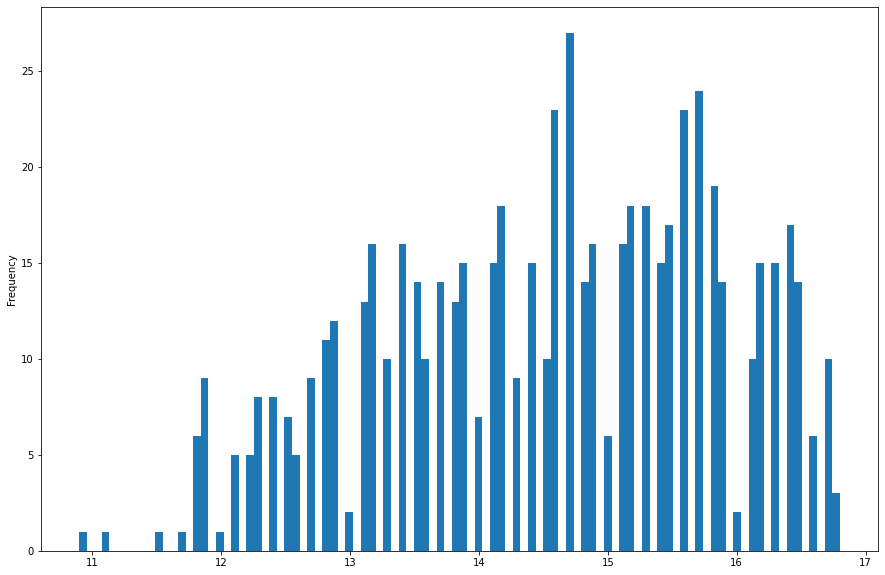

In [41]:
ferma_main['эке'].plot(kind ='hist', bins=100, figsize=(15,10));

Показатель питательности корма коровы находится в диапазоне от 10,9 до 16.8.

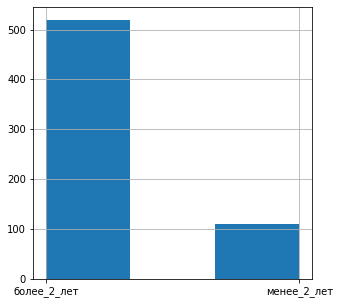

In [42]:
ferma_main.возраст.hist(bins = 3, figsize = (5,5));

Основная масса коров перевалила за отметку в возрасте в 2 года.

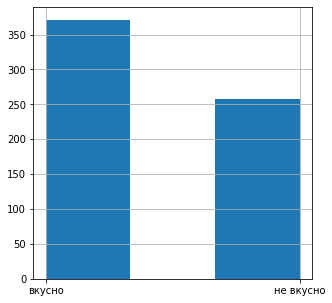

In [43]:
ferma_main.вкус_молока.hist(bins = 3, figsize = (5,5));

По субьективной оценки вкуса молока у фермера,превалирует вкусное молоко  ≈ 370 против  ≈ 260.

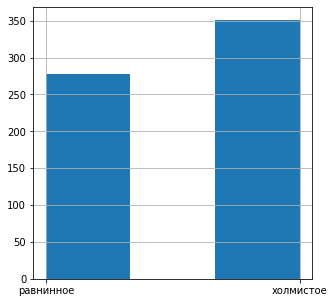

In [44]:
ferma_main.тип_пастбища.hist(bins = 3, figsize = (5,5));

Большее количество коров пасется на холмистой местности  ≈ 350 против  ≈ 275 на равнинной.

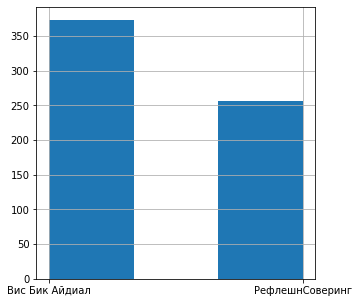

In [45]:
ferma_main.порода.hist(bins = 3, figsize = (5,5));

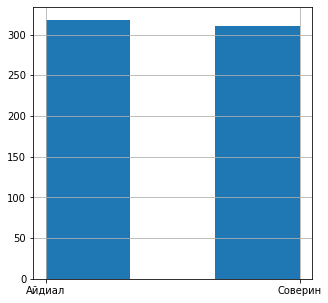

In [46]:
ferma_main.порода_папы_быка.hist(bins = 3, figsize = (5,5));

Порода папы быка у коров имеют одинаковое количесто и поделены на 2 породы.

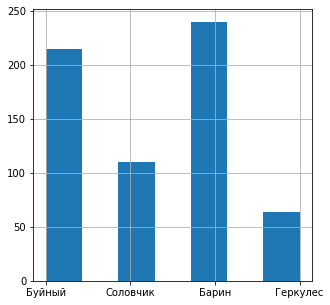

In [47]:
ferma_dad.имя_папы.hist(bins = 7, figsize = (5,5));

В таблице **ferma_dad** быков с именами **Буйный** и **Барин** большее количество.

In [48]:
cow_buy.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
порода,20,2,РефлешнСоверинг,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
тип_пастбища,20,2,равнинное,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
порода_папы_быка,20,2,Соверин,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
имя_папы,20,4,Буйный,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
жирность,20.0,NaN,NaN,NaN,3.5775,0.126818,3.34,3.51,3.59,3.65,3.77
белок,20.0,NaN,NaN,NaN,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081
возраст,20,2,более_2_лет,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Постмотрел основные статистические характеристики данных по каждому признаку таблицы **cow_buy**, явных выбросов не замечено.

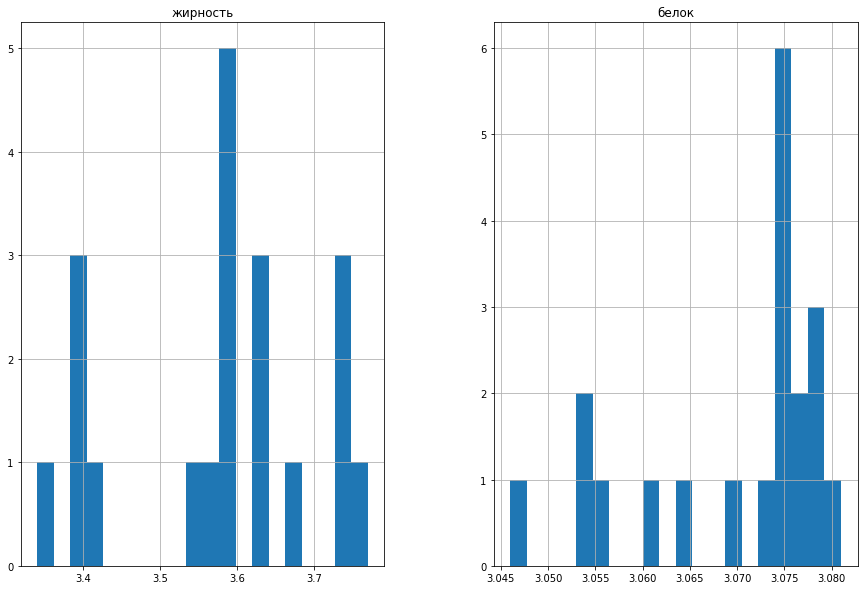

In [49]:
cow_buy.hist(bins = 20, figsize = (15,10));

Данные о содержании белка и жирности молока у покупаемых коров, в столбце **жирность** данные распределены НЕнормально.

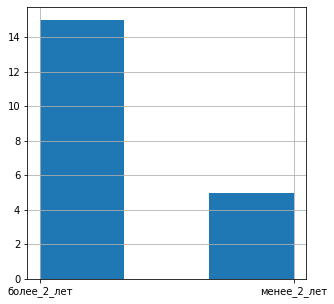

In [50]:
cow_buy.возраст.hist(bins = 3, figsize = (5,5));

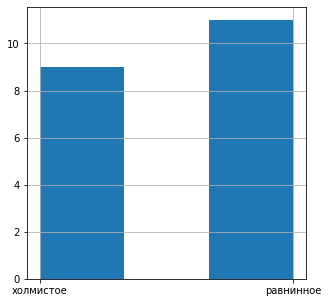

In [51]:
cow_buy.тип_пастбища.hist(bins = 3, figsize = (5,5));

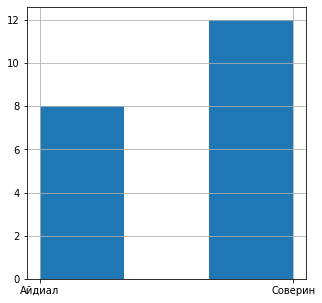

In [52]:
cow_buy.порода_папы_быка.hist(bins = 3, figsize = (5,5));

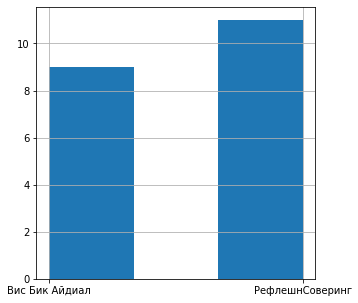

In [53]:
cow_buy.порода.hist(bins = 3, figsize = (5,5));

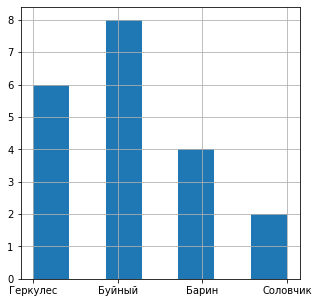

In [54]:
cow_buy.имя_папы.hist(bins = 7, figsize = (5,5));

Тут так же преобладают коровы с возрастом более 2 лет, большая часть пасется на равнинной местности, преобладают породы Соверинг и в столбце с породой папы быка и в столбце **порода**.Больше всего коров у Буйного,потом идет Геркулес, за ним Барин и последний Соловчик.

## Корреляционный анализ

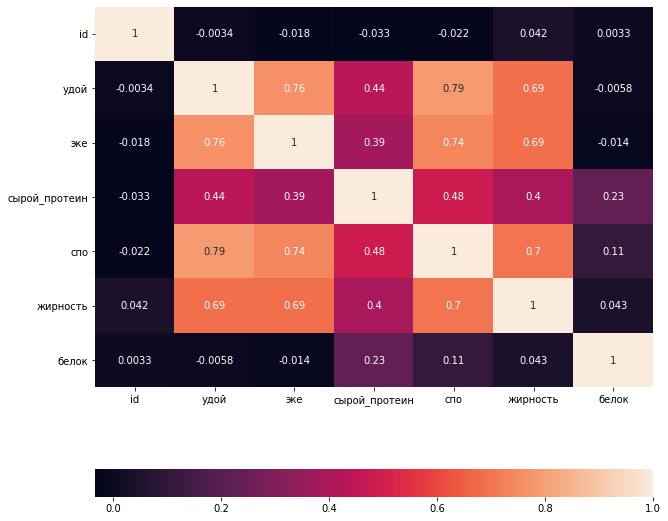

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(ferma_main.corr(method='spearman'), annot = True, cbar_kws= {'orientation': 'horizontal'});

Построил тепловую карту корреляции Спирмена, наблюдаем взаимосвязь между признаками в таблице **ferma_main**, признак **удой** коррелирует с **эке**, **спо** и **жирностью**, есть связь между **спо** и **жирностью**, так же наблюдаем слабую связь **сырой_протеин** с **удой**, **эке**, **спо** и **жирностью** примерно в равном количестве.

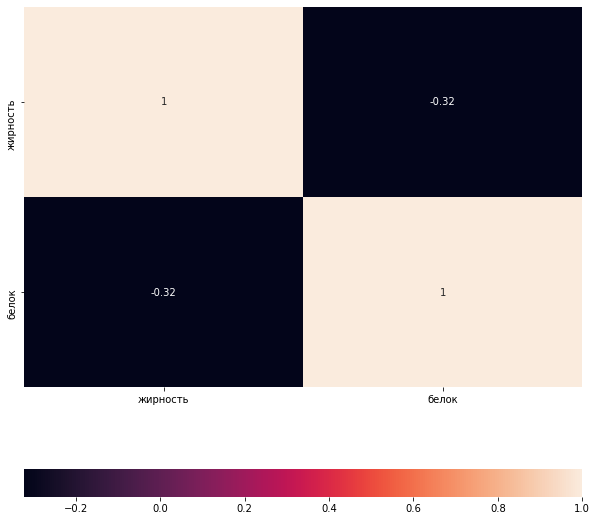

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cow_buy.corr(method='spearman'), annot = True, cbar_kws= {'orientation': 'horizontal'});

Связи между содержанием белка и жирностью в таблице **cow_buy** не наблюдается.

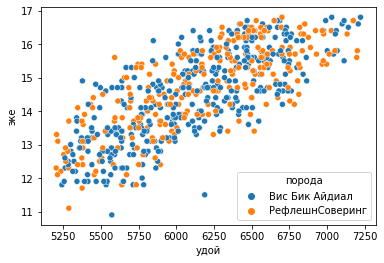

In [57]:
sns.scatterplot(data=ferma_main, x='удой', y='эке', hue = 'порода');

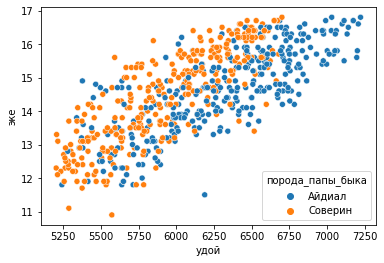

In [58]:
sns.scatterplot(data=ferma_main, x='удой', y='эке', hue = 'порода_папы_быка');

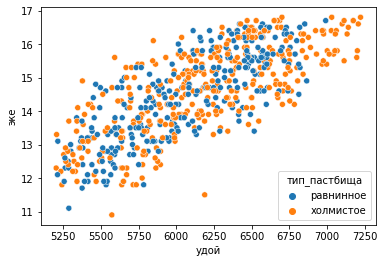

In [59]:
sns.scatterplot(data=ferma_main, x='удой', y='эке', hue = 'тип_пастбища');

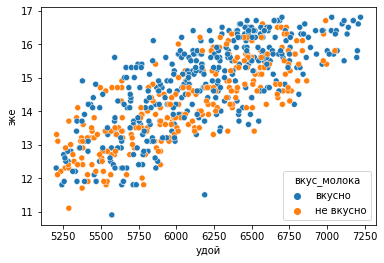

In [60]:
sns.scatterplot(data=ferma_main, x='удой', y='эке', hue = 'вкус_молока');

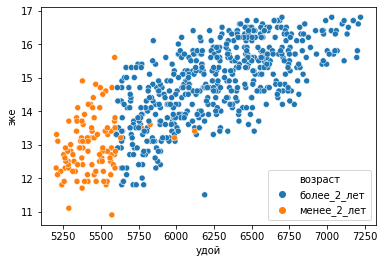

In [61]:
sns.scatterplot(data=ferma_main, x='удой', y='эке', hue = 'возраст');

Построил диаграммы рассеяния для целевого признака **удой** и количественного значения **эке** с учетом категориальных признаков.Наблюдаю линейную взаимосвязь,распределение данных по категориальным признакам такое:
**Тип пастбища**, **вкус молока** и **порода** равномерное
У коров,возраст которых перевалил за отметку в 2 года,  значение экэ способствует большему удою,нежели у коров младше 2 лет
У тех коров,у которых порода папы быка **Айдал**,удой больше в отличие от породы **Соверинг**.

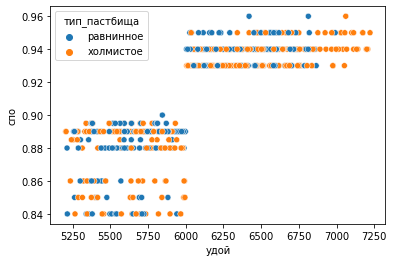

In [62]:
sns.scatterplot(data=ferma_main, x='удой', y='спо', hue = 'тип_пастбища');

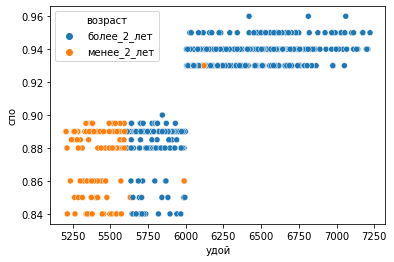

In [63]:
sns.scatterplot(data=ferma_main, x='удой', y='спо', hue = 'возраст');

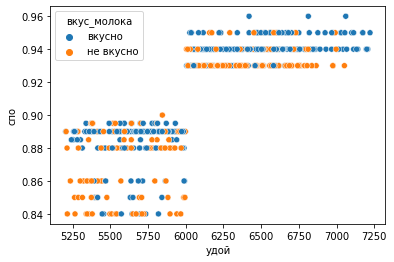

In [64]:
sns.scatterplot(data=ferma_main, x='удой', y='спо', hue = 'вкус_молока');

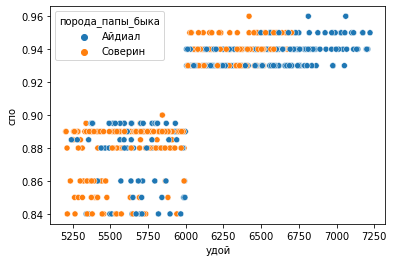

In [65]:
sns.scatterplot(data=ferma_main, x='удой', y='спо', hue = 'порода_папы_быка');

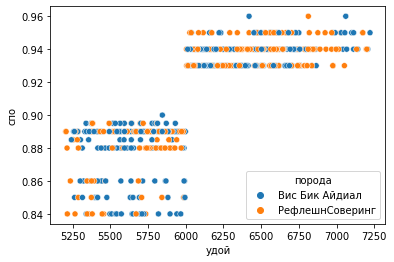

In [66]:
sns.scatterplot(data=ferma_main, x='удой', y='спо', hue = 'порода');

На первый взгляд взаимосвязь не линейная,в дальнейшем необходимо сделать градацию признака **спо** до 0,9 и более 0,9.
Так же как и с признаком **эке**,коровы младше 2 лет находятся в группе с небольшим **спо** и **удоем**.

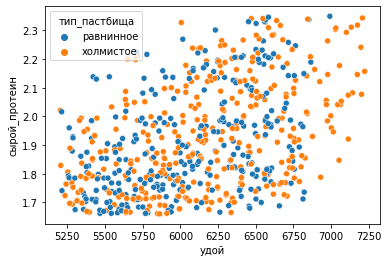

In [67]:
sns.scatterplot(data=ferma_main, x='удой', y='сырой_протеин', hue = 'тип_пастбища');

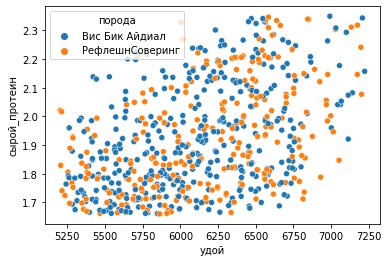

In [68]:
sns.scatterplot(data=ferma_main, x='удой', y='сырой_протеин', hue = 'порода');

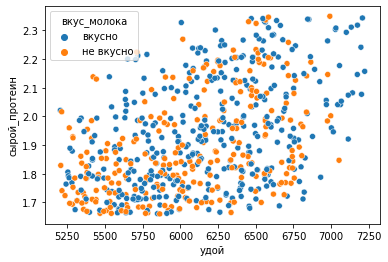

In [69]:
sns.scatterplot(data=ferma_main, x='удой', y='сырой_протеин', hue = 'вкус_молока');

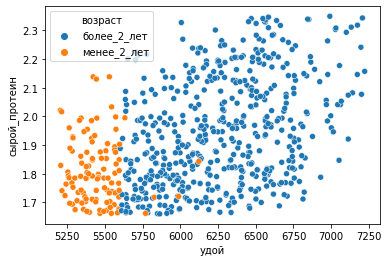

In [70]:
sns.scatterplot(data=ferma_main, x='удой', y='сырой_протеин', hue = 'возраст');

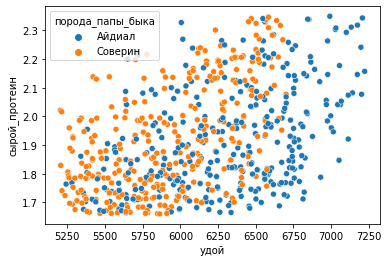

In [71]:
sns.scatterplot(data=ferma_main, x='удой', y='сырой_протеин', hue = 'порода_папы_быка');

Сырой протеин способствует удою у коров с возрастом более 2 лет,остальные данные распеределены равномерно.

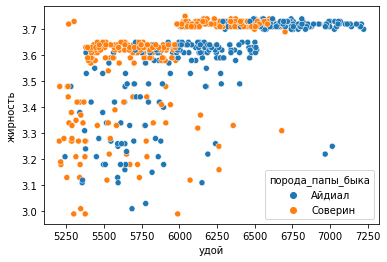

In [72]:
sns.scatterplot(data=ferma_main, x='удой', y='жирность', hue = 'порода_папы_быка');

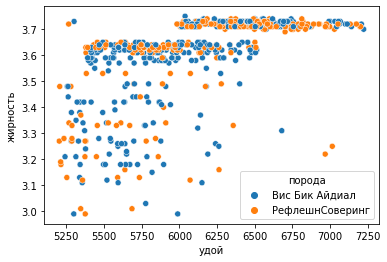

In [73]:
sns.scatterplot(data=ferma_main, x='удой', y='жирность', hue = 'порода');

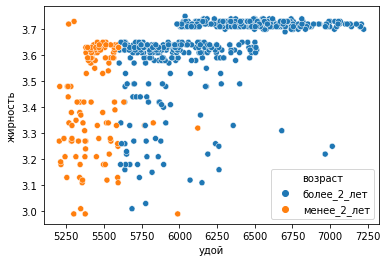

In [74]:
sns.scatterplot(data=ferma_main, x='удой', y='жирность', hue = 'возраст');

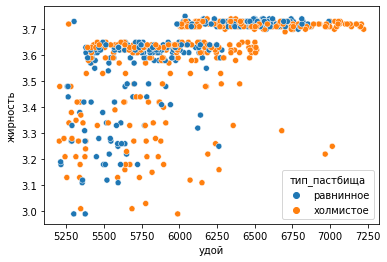

In [75]:
sns.scatterplot(data=ferma_main, x='удой', y='жирность', hue = 'тип_пастбища');

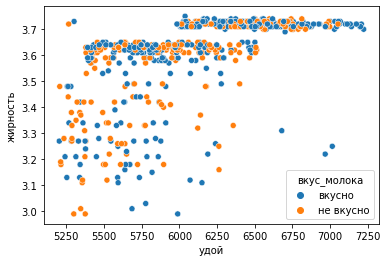

In [76]:
sns.scatterplot(data=ferma_main, x='удой', y='жирность', hue = 'вкус_молока');

Большая часть коров дает молоко с жирностью в верхних границах и делится на 2 категории  ≈3,6 и  ≈3,7,тут так же возраст распределен следующим образом:
возраст более 2 лет с высокой жирностью и большим удоем.

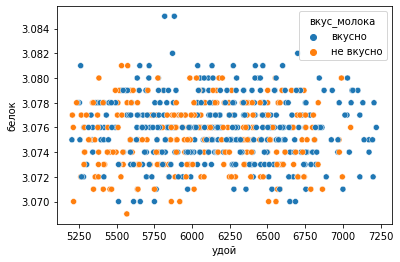

In [77]:
sns.scatterplot(data=ferma_main, x='удой', y='белок', hue = 'вкус_молока');

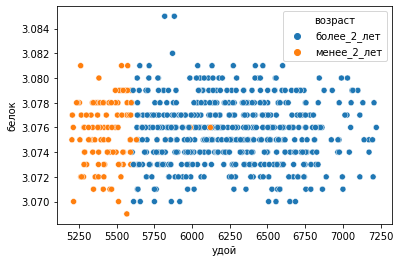

In [78]:
sns.scatterplot(data=ferma_main, x='удой', y='белок', hue = 'возраст');

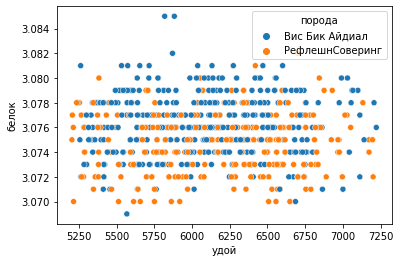

In [79]:
sns.scatterplot(data=ferma_main, x='удой', y='белок', hue = 'порода');

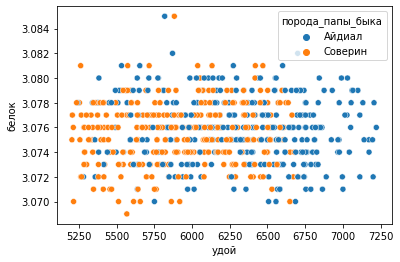

In [80]:
sns.scatterplot(data=ferma_main, x='удой', y='белок', hue = 'порода_папы_быка');

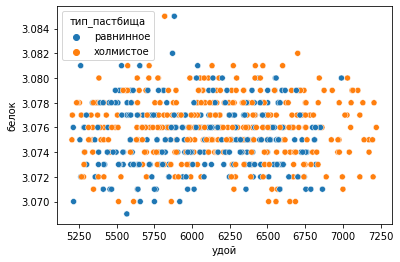

In [81]:
sns.scatterplot(data=ferma_main, x='удой', y='белок', hue = 'тип_пастбища');

Содержание белка не связано с удоем.

Мультиколлениарность не наблюдается.

## Обучение модели линейной регрессии №1

In [82]:
df_lr_1 = ferma_main.copy()
df_lr_1

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863.0,14.2,1.743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529.0,12.8,2.138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810.0,14.0,1.854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895.0,12.4,2.012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302.0,12.8,1.675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812.0,15.4,1.964,0.940,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
625,626,5513.0,12.9,1.700,0.880,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970.0,14.4,1.837,0.880,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
627,628,5746.0,13.8,1.994,0.890,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,вкусно,более_2_лет


In [83]:
RANDOM_STATE = 42

X = df_lr_1.drop('удой', axis=1)
y = df_lr_1['удой']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25,
    random_state=RANDOM_STATE
)
for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(471, 11)
(471,)
(158, 11)
(158,)


Разбил данные на признаки и целевой признак,далее задал пропорции классов с соотношением тренировочная/тестовая 75%/25%

In [84]:
ohe_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
num_features = ['эке', 'сырой_протеин', 'спо']

In [85]:
X_train = X_train.copy().drop(['id', 'жирность', 'белок', 'вкус_молока'], axis=1)
X_test = X_test.copy().drop(['id', 'жирность', 'белок', 'вкус_молока'], axis=1)

В расчет не взял признак **вкус молока**,так как этот субъективный признак и никак не влияет на удой, так же **удой** не зависит от жирности и содержания белка в молоке.**спо** оставил, так как этот показатель имеет причинно-следственные связи с удоем.

In [86]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [87]:
encoder_ohe.fit(X_train[ohe_features])

X_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train[ohe_features])

X_train = X_train.drop(ohe_features, axis=1)

In [88]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])

X_train.head()

,эке,сырой_протеин,спо,порода_РефлешнСоверинг,тип_пастбища_холмистое,порода_папы_быка_Соверин,возраст_менее_2_лет
612,0.016344,0.248479,0.814135,0.0,0.0,0.0,0.0
587,0.095707,-1.392310,-1.072496,0.0,0.0,0.0,0.0
196,0.016344,1.124306,0.499697,0.0,1.0,0.0,0.0
328,-1.174092,0.858232,-0.758057,0.0,0.0,0.0,0.0
259,0.571881,-0.671693,0.499697,1.0,1.0,0.0,0.0


In [89]:
X_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test[ohe_features])

X_test = X_test.drop(ohe_features, axis=1)

X_test[num_features] = scaler.transform(
    X_test[num_features]
)

X_test.head()

,эке,сырой_протеин,спо,порода_РефлешнСоверинг,тип_пастбища_холмистое,порода_папы_быка_Соверин,возраст_менее_2_лет
494,-1.491541,-1.198298,-2.015811,0.0,1.0,1.0,1.0
244,1.286143,-0.915594,0.814135,0.0,1.0,1.0,0.0
551,-0.539192,-0.677236,-1.701373,1.0,1.0,1.0,1.0
213,-0.777280,-0.588545,0.499697,0.0,0.0,1.0,0.0
532,0.651243,-1.159496,-0.758057,1.0,1.0,1.0,0.0


In [90]:
X_train.shape, X_test.shape

((471, 7), (158, 7))

In [91]:
(X_train.columns != X_test.columns).sum()

0

Маштабировал числовые даные через StandardScalerdScaler, так же кодировал категориальные признаки с помощью OneHotEncoder.

In [92]:
model  = LinearRegression()
model.fit(X_train, y_train)
predictions_1 = model.predict(X_test)

Обучил модель, использовал алгорит Линейной Регрессии.

In [93]:
r2 = r2_score(y_test, predictions_1)  
print("R2 LinearRegression =", r2)

R2 LinearRegression = 0.8188648615891243


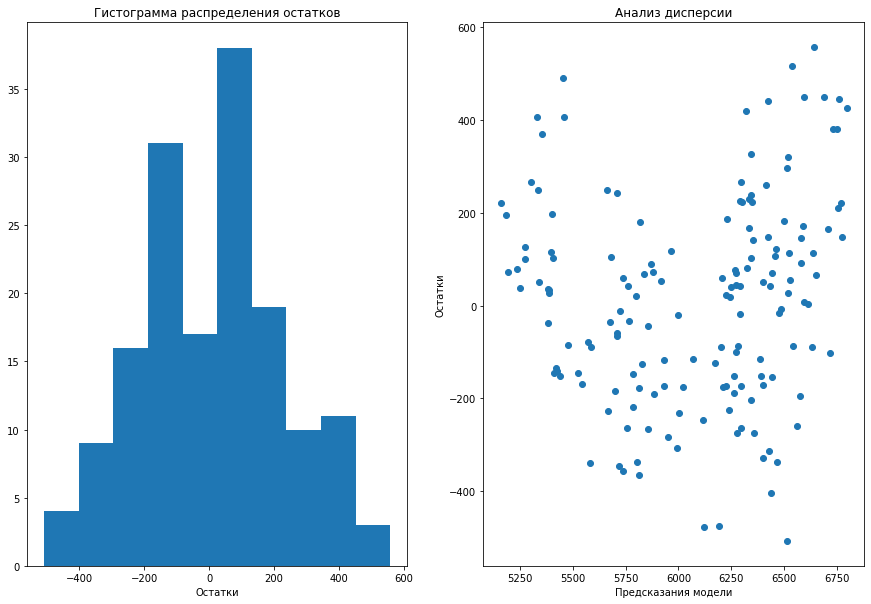

In [94]:
residuals_1 = y_test - predictions_1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
axes[0].hist(residuals_1)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_1, residuals_1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод:** Коэффициент детерминации у первой модели 0,82.Судя по графику наблюдаю бимодальное распределение без смещения. Имеем нормальную дисперсию остатков.
Необходимы дополнительные исследования что бы улучшить модель.

## Обучение модели линейной регрессии №2

In [95]:
df_lr_2 = ferma_main.copy()

df_lr_2.loc[df_lr_2['спо'] > 0.9, 'спо'] = 1
df_lr_2.loc[df_lr_2['спо'] <= 0.9, 'спо'] = 0

df_lr_2['эке'] = ferma_main['эке']**2
df_lr_2.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863.0,201.64,1.743,0.0,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529.0,163.84,2.138,0.0,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810.0,196.00,1.854,0.0,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895.0,153.76,2.012,0.0,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302.0,163.84,1.675,0.0,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


Исключил нелинейность,преобразовал **спо** в категориальный бинарный признак,с порогами до 0,9 и от 0,9 и
**эке** возвел в квадрат.

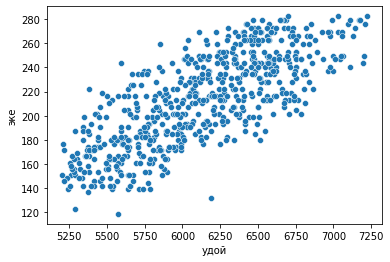

In [96]:
sns.scatterplot(data=df_lr_2, x="удой", y="эке");

In [97]:
RANDOM_STATE = 42

X = df_lr_2.drop('удой', axis=1)
y = df_lr_2['удой']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25,
    random_state=RANDOM_STATE
)
for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(471, 11)
(471,)
(158, 11)
(158,)


Разбил данные на признаки и целевой признак,далее задал пропорции классов с соотношением тренировочная/тестовая 75%/25%

In [98]:
ohe_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
num_features = ['эке', 'сырой_протеин']

In [99]:
X_train = X_train.copy().drop(['id', 'жирность', 'белок', 'вкус_молока'], axis=1)
X_test = X_test.copy().drop(['id', 'жирность', 'белок', 'вкус_молока'], axis=1)

В расчет так же не взял признак **вкус молока**,так как этот субъективный признак и никак не влияет на удой, так же **удой** не зависит от жирности и содержания белка в молоке.**спо** оставил, так как этот показатель имеет причинно-следственные связи с удоем.Так же не стал кодировать и так бинарный признак **спо**.

In [100]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(X_train[ohe_features])

X_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train[ohe_features])

X_train = X_train.drop(ohe_features, axis=1)

In [101]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])

X_train.head()

,эке,сырой_протеин,спо,порода_РефлешнСоверинг,тип_пастбища_холмистое,порода_папы_быка_Соверин,возраст_менее_2_лет
612,-0.027210,0.248479,1.0,0.0,0.0,0.0,0.0
587,0.053583,-1.392310,0.0,0.0,0.0,0.0,0.0
196,-0.027210,1.124306,1.0,0.0,1.0,0.0,0.0
328,-1.172927,0.858232,0.0,0.0,0.0,0.0,0.0
259,0.549923,-0.671693,1.0,1.0,1.0,0.0,0.0


In [102]:
X_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test[ohe_features])

X_test = X_test.drop(ohe_features, axis=1)

X_test[num_features] = scaler.transform(
    X_test[num_features]
)

X_test.head()

,эке,сырой_протеин,спо,порода_РефлешнСоверинг,тип_пастбища_холмистое,порода_папы_быка_Соверин,возраст_менее_2_лет
494,-1.457496,-1.198298,0.0,0.0,1.0,1.0,1.0
244,1.331658,-0.915594,1.0,0.0,1.0,1.0,0.0
551,-0.577320,-0.677236,0.0,1.0,1.0,1.0,1.0
213,-0.804809,-0.588545,1.0,0.0,0.0,1.0,0.0
532,0.634577,-1.159496,0.0,1.0,1.0,1.0,0.0


Маштабировал числовые даные через StandardScalerdScaler, так же кодировал категориальные признаки с помощью OneHotEncoder.

In [103]:
X_train.shape, X_test.shape

((471, 7), (158, 7))

In [104]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions_2 = model.predict(X_test)
r2 = r2_score(y_test, predictions_2)  
"R2 LinearRegression =", r2

('R2 LinearRegression =', 0.8436276672776312)

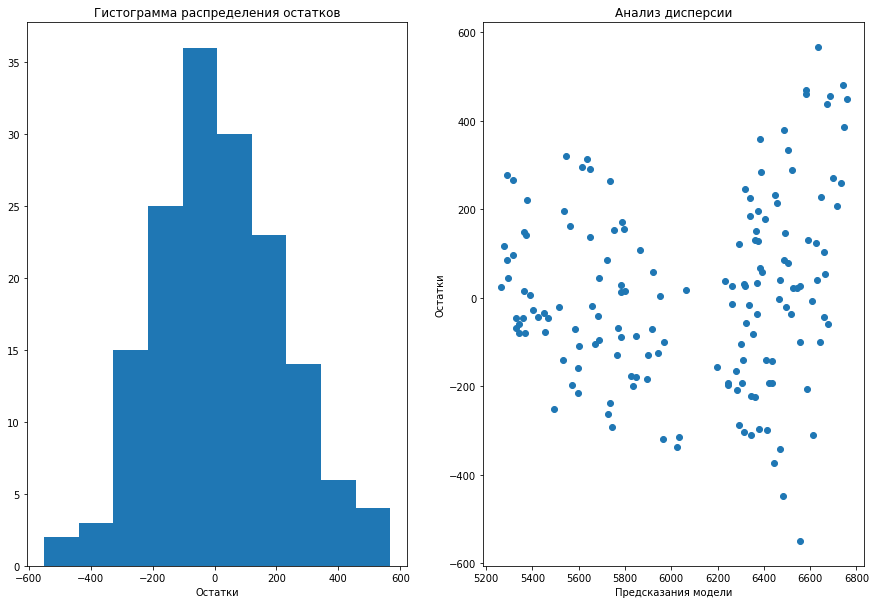

In [105]:
residuals_2 = y_test - predictions_2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
axes[0].hist(residuals_2)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_2, residuals_2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод:** Коэффициент детерминации у второй модели  лучше и составляет 0,84.Судя по графику наблюдаю симметричное нормально распределение.Дисперсия остатков похожа на рупор,попробуем добавить дополнительные признаки и улучшить данный показатель.

## Обучение модели линейной регрессии №3

In [106]:
df_lr_3 = ferma_main.copy()

df_lr_3.loc[df_lr_3['спо'] > 0.9, 'спо'] = 1
df_lr_3.loc[df_lr_3['спо'] <= 0.9, 'спо'] = 0

df_lr_3['эке'] = df_lr_3['эке']**2
df_lr_3.head()

,id,удой,эке,сырой_протеин,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863.0,201.64,1.743,0.0,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529.0,163.84,2.138,0.0,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810.0,196.00,1.854,0.0,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895.0,153.76,2.012,0.0,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302.0,163.84,1.675,0.0,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


Исключил нелинейность,преобразовал спо в категориальный бинарный признак,с порогами до 0,9 и от 0,9 и эке возвел в квадрат.

In [107]:
df_lr_3 = df_lr_3.merge(ferma_dad, how  ='inner', on = 'id')
df_lr_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                629 non-null    int64  
 1   удой              629 non-null    float64
 2   эке               629 non-null    float64
 3   сырой_протеин     629 non-null    float64
 4   спо               629 non-null    float64
 5   порода            629 non-null    object 
 6   тип_пастбища      629 non-null    object 
 7   порода_папы_быка  629 non-null    object 
 8   жирность          629 non-null    float64
 9   белок             629 non-null    float64
 10  вкус_молока       629 non-null    object 
 11  возраст           629 non-null    object 
 12  имя_папы          629 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 68.8+ KB


Добавил новый признак с таблицы **ferma_dad**.

In [108]:
RANDOM_STATE = 42

X = df_lr_3.drop('удой', axis=1)
y = df_lr_3['удой']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25,
    random_state=RANDOM_STATE
)
for i in [X_train, y_train, X_test, y_test]:
    print(i.shape)

(471, 12)
(471,)
(158, 12)
(158,)


Разбил данные на признаки и целевой признак,далее задал пропорции классов с соотношением тренировочная/тестовая 75%/25%

In [109]:
ohe_features = ['порода', 'тип_пастбища', 'возраст', 'имя_папы']
num_features = ['эке', 'сырой_протеин']

In [110]:
X_train = X_train.copy().drop(['id', 'жирность', 'белок', 'вкус_молока', 'порода_папы_быка'], axis=1)
X_test = X_test.copy().drop(['id', 'жирность', 'белок', 'вкус_молока', 'порода_папы_быка'], axis=1)

В расчет так же не взял признак вкус молока,так как этот субъективный признак и никак не влияет на удой, так же удой не зависит от жирности и содержания белка в молоке, убрал столбец **порода_папы_быка**,так как он сильно коррелирует с **имя папы**.спо оставил, так как этот показатель имеет причинно-следственные связи с удоем.Так же не стал кодировать и так бинарный признак спо.

In [111]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(X_train[ohe_features])

X_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train[ohe_features])

X_train = X_train.drop(ohe_features, axis=1)

In [112]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])

X_train.head()

,эке,сырой_протеин,спо,порода_РефлешнСоверинг,тип_пастбища_холмистое,возраст_менее_2_лет,имя_папы_Буйный,имя_папы_Геркулес,имя_папы_Соловчик
612,-0.027210,0.248479,1.0,0.0,0.0,0.0,1.0,0.0,0.0
587,0.053583,-1.392310,0.0,0.0,0.0,0.0,1.0,0.0,0.0
196,-0.027210,1.124306,1.0,0.0,1.0,0.0,1.0,0.0,0.0
328,-1.172927,0.858232,0.0,0.0,0.0,0.0,0.0,1.0,0.0
259,0.549923,-0.671693,1.0,1.0,1.0,0.0,1.0,0.0,0.0


In [113]:
X_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test[ohe_features])

X_test = X_test.drop(ohe_features, axis=1)

X_test[num_features] = scaler.transform(
    X_test[num_features]
)

X_test.head()

,эке,сырой_протеин,спо,порода_РефлешнСоверинг,тип_пастбища_холмистое,возраст_менее_2_лет,имя_папы_Буйный,имя_папы_Геркулес,имя_папы_Соловчик
494,-1.457496,-1.198298,0.0,0.0,1.0,1.0,0.0,0.0,0.0
244,1.331658,-0.915594,1.0,0.0,1.0,0.0,0.0,0.0,0.0
551,-0.577320,-0.677236,0.0,1.0,1.0,1.0,0.0,0.0,0.0
213,-0.804809,-0.588545,1.0,0.0,0.0,0.0,0.0,0.0,0.0
532,0.634577,-1.159496,0.0,1.0,1.0,0.0,0.0,0.0,1.0


Маштабировал числовые даные через StandardScalerdScaler, так же кодировал категориальные признаки с помощью OneHotEncoder.

In [114]:
X_train.shape, X_test.shape

((471, 9), (158, 9))

In [115]:
model  = LinearRegression()
model.fit(X_train, y_train)
predictions_3 = model.predict(X_test)
r2 = r2_score(y_test, predictions_3)  
'R2 LinearRegression =' , r2

('R2 LinearRegression =', 0.8624312645405668)

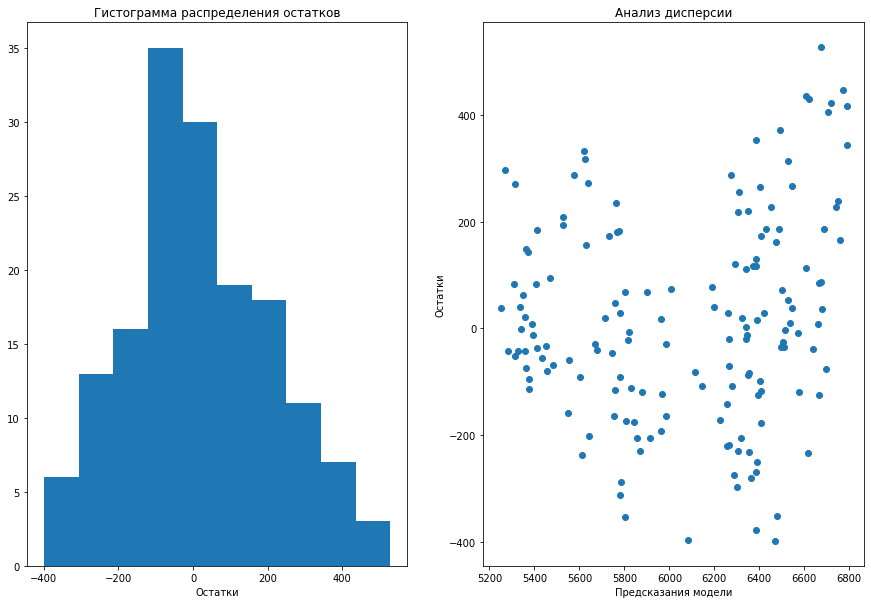

In [116]:
residuals_3 = y_test - predictions_3

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
axes[0].hist(residuals_3)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_3, residuals_3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод:** Коэффициент детерминации у второй модели  лучше и составляет 0,86.Судя по графику наблюдаю асимметричное нормально распределение с небольшим смещением вправо.Дисперсия остатков имеет нормальный разброс.

In [117]:
def func(a, b, c):
    mae = mean_absolute_error(b, c)
    mse = mean_squared_error(b, c)
    rmse = np.sqrt(mse)
    print(a, ', mae:',mae, ', mse:', mse, ', rmse:', rmse)

In [118]:
func('model1', y_test, predictions_1)

model1 , mae: 181.06874799289022 , mse: 49633.89323228776 , rmse: 222.78665407130597


In [119]:
func('model2',y_test, predictions_2)

model2 , mae: 163.8753868070714 , mse: 42848.49276025301 , rmse: 206.99877477959382


In [120]:
func('model3',y_test, predictions_3)

model3 , mae: 153.47438325068288 , mse: 37696.00966327124 , rmse: 194.15460247769363


In [121]:
st.norm.interval(0.99 , loc=np.mean(predictions_3), scale=st.sem(predictions_3))

(5975.7698593613795, 6164.525124474188)

Существует вероятность 99%, что доверительный интервал [5975.61, 6164.39] содержит истинную среднюю удоя коров.

Третяя модель оказась самой лучшей, в среднем она отклоняется от истинного значения на 153,4.

## Выбрав лучшую модель, делаем прогноз

In [122]:
cow_buy_1 = cow_buy.copy()

In [123]:
cow_buy_1[['эке', 'сырой_протеин', 'спо']] = ferma_main[['эке', 'сырой_протеин', 'спо']].mean()*1.05

Добавил недостающие признаки в таблицу **cow_buy** и увеличил их среднюю на 5%.

In [124]:
cow_buy_1.loc[cow_buy_1['спо']>0.9, ['спо']] = 1
cow_buy_1.loc[cow_buy_1['спо']<=0.9, ['спо']] = 0

cow_buy_1['эке'] = cow_buy_1['эке']**2

In [125]:
X_test = cow_buy_1.copy().drop(['жирность', 'белок', 'порода_папы_быка'], axis=1)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   порода         20 non-null     object 
 1   тип_пастбища   20 non-null     object 
 2   имя_папы       20 non-null     object 
 3   возраст        20 non-null     object 
 4   эке            20 non-null     float64
 5   сырой_протеин  20 non-null     float64
 6   спо            20 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.2+ KB


In [126]:
X_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test[ohe_features])

X_test = X_test.drop(ohe_features, axis=1)

X_test[num_features] = scaler.transform(
    X_test[num_features]
)

X_test.head()

,эке,сырой_протеин,спо,порода_РефлешнСоверинг,тип_пастбища_холмистое,возраст_менее_2_лет,имя_папы_Буйный,имя_папы_Геркулес,имя_папы_Соловчик
0,0.525538,0.539677,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.525538,0.539677,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.525538,0.539677,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.525538,0.539677,1.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.525538,0.539677,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [127]:
X_train.shape, X_test.shape

((471, 9), (20, 9))

In [128]:
predictions_4 = model.predict(X_test)
predictions_4

array([6550.2655493 , 6288.45056674, 6287.66528973, 6595.08354225,
       6542.40369951, 6334.45120415, 6550.2655493 , 6496.99438433,
       6287.66528973, 6386.53972466, 6348.38861788, 6542.99502174,
       6550.2655493 , 6086.39199969, 6287.66528973, 6595.08354225,
       6348.38861788, 6334.45120415, 6496.99438433, 6542.40369951])

In [129]:
prediction_model = cow_buy[cow_buy.columns]
prediction_model['удой'] = predictions_4
prediction_model

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,удой
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6550.265549
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6288.450567
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6287.665290
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6595.083542
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6542.403700
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6334.451204
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6550.265549
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6496.994384
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6287.665290
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6386.539725


Получил прогноз удоя коров «ЭкоФермы».

## Обучение модели логистической регрессии

In [130]:
df_log = ferma_main.copy()
df_log = df_log.drop('удой', axis=1)

In [131]:
df_log.loc[df_log['спо']<0.9, ['спо']] = 0
df_log.loc[df_log['спо']>=0.9, ['спо']] = 1
df_log['эке'] = df_log['эке']**2
df_log['вкус_молока'] = df_log['вкус_молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

In [132]:
RANDOM_STATE = 42

X = df_log.drop('вкус_молока', axis=1)
y = df_log['вкус_молока']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25,
    random_state=RANDOM_STATE)

Разбил данные на признаки и целевой признак,далее задал пропорции классов с соотношением тренировочная/тестовая 75%/25%

In [133]:
ohe_features = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст']
num_features = ['эке', 'сырой_протеин', 'жирность', 'белок']

In [134]:
X_train = X_train.copy()
X_test = X_test.copy()

In [135]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(X_train[ohe_features])

X_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train[ohe_features])

X_train = X_train.drop(ohe_features, axis=1)

In [136]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])

X_train.head()

,id,эке,сырой_протеин,спо,жирность,белок,порода_РефлешнСоверинг,тип_пастбища_холмистое,порода_папы_быка_Соверин,возраст_менее_2_лет
612,613,-0.027210,0.248479,1.0,0.199205,1.666305,0.0,0.0,0.0,0.0
587,588,0.053583,-1.392310,0.0,-2.618012,1.283462,0.0,0.0,0.0,0.0
196,197,-0.027210,1.124306,1.0,0.076717,0.517774,0.0,1.0,0.0,0.0
328,329,-1.172927,0.858232,0.0,0.199205,0.134930,0.0,0.0,0.0,0.0
259,260,0.549923,-0.671693,1.0,0.566668,-2.162133,1.0,1.0,0.0,0.0


In [137]:
X_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test[ohe_features])

X_test = X_test.drop(ohe_features, axis=1)

X_test[num_features] = scaler.transform(
    X_test[num_features]
)

X_test.head() 

,id,эке,сырой_протеин,спо,жирность,белок,порода_РефлешнСоверинг,тип_пастбища_холмистое,порода_папы_быка_Соверин,возраст_менее_2_лет
494,495,-1.457496,-1.198298,0.0,-1.576866,-0.247914,0.0,1.0,1.0,1.0
244,245,1.331658,-0.915594,1.0,0.689156,-0.247914,0.0,1.0,1.0,0.0
551,552,-0.577320,-0.677236,0.0,0.137961,0.134930,1.0,1.0,1.0,1.0
213,214,-0.804809,-0.588545,1.0,0.689156,-0.630758,0.0,0.0,1.0,0.0
532,533,0.634577,-1.159496,0.0,0.137961,0.134930,1.0,1.0,1.0,0.0


Маштабировал числовые даные через StandardScalerdScaler, так же кодировал категориальные признаки с помощью OneHotEncoder.

In [138]:
X_train.shape, X_test.shape

((471, 10), (158, 10))

In [139]:
clf = LogisticRegression(random_state=RANDOM_STATE)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [140]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)


print("Accuracy на тестовой выборке:", acc)
print('Recall на тестовой выборке: ', recall)
print('Precision на тестовой выборке: ', precision)

Accuracy на тестовой выборке: 0.7025316455696202
Recall на тестовой выборке:  0.8041237113402062
Precision на тестовой выборке:  0.7358490566037735


In [141]:
confusion_matrix= confusion_matrix(y_test, y_pred)

confusion_matrix

array([[33, 28],
       [19, 78]])

Доля правильных ответов на тестовой выборке: 0.7025, значение Recall выше чем Precision, построив матрицу ошибок, видно что модель ошибается в 28 случаях,присваивая класс 1,хотя на самом деле он 0(не вкусное).Так как нам нужно минимизировать количество ошибок первого рода, в дальнейшем нужно работать с Precision.

In [142]:
y_proba = clf.predict_proba(X_test)[:,1]

df_p = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_test', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(df_p.head())

     y_test   y_proba
56        1  0.884737
146       1  0.877895
77        1  0.862138
65        1  0.845116
85        1  0.819517


In [143]:
thresholds = [round(i,2) for i in np.linspace(0.6,0.9,num = 13,endpoint=False)]
print(thresholds) 

[0.6, 0.62, 0.65, 0.67, 0.69, 0.72, 0.74, 0.76, 0.78, 0.81, 0.83, 0.85, 0.88]


In [144]:
metrics = []
metrics_1 = []
# В цикле будем перебирать сгенерированные пороги
for i in thresholds:
    y_pred_1 = df_p['y_proba'].apply(lambda x: 1 if x>i else 0)
    metrics.append(precision_score(df_p['y_test'], y_pred_1))
    metrics_1.append(recall_score(df_p['y_test'], y_pred_1))
    
print(metrics)


[0.7681159420289855, 0.7777777777777778, 0.7931034482758621, 0.8222222222222222, 0.8205128205128205, 0.8, 0.8181818181818182, 0.8823529411764706, 0.8666666666666667, 1.0, 1.0, 1.0, 1.0]


In [145]:
print(metrics_1)

[0.5463917525773195, 0.5051546391752577, 0.4742268041237113, 0.38144329896907214, 0.32989690721649484, 0.24742268041237114, 0.18556701030927836, 0.15463917525773196, 0.13402061855670103, 0.09278350515463918, 0.041237113402061855, 0.030927835051546393, 0.010309278350515464]


Оптимальный порог,который минимизирует ошибку первого рода,является 0,81.


In [146]:
X_test = cow_buy.copy()
X_test[['эке', 'сырой_протеин','спо']] = ferma_main[['эке', 'сырой_протеин','спо']].mean()*1.05
X_test.loc[X_test['спо']<0.9, ['спо']] = 0
X_test.loc[X_test['спо']>=0.9, ['спо']] = 1

X_test['эке'] = X_test['эке']**2


X_test = X_test.drop('имя_папы', axis=1)

In [147]:
X_test["id"] = X_test.index + 1

In [148]:
X_train.shape, X_test.shape

((471, 10), (20, 10))

In [149]:
X_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test[ohe_features])

X_test = X_test.drop(ohe_features, axis=1)

X_test[num_features] = scaler.transform(
    X_test[num_features]
)

X_test.head()

,жирность,белок,эке,сырой_протеин,спо,id,порода_РефлешнСоверинг,тип_пастбища_холмистое,порода_папы_быка_Соверин,возраст_менее_2_лет
0,-0.168258,0.134930,0.525538,0.539677,1.0,1,0.0,1.0,0.0,0.0
1,-0.413233,2.049149,0.525538,0.539677,1.0,2,0.0,0.0,1.0,1.0
2,-0.107014,-0.630758,0.525538,0.539677,1.0,3,1.0,0.0,1.0,0.0
3,-1.270647,-5.607727,0.525538,0.539677,1.0,4,1.0,1.0,0.0,0.0
4,0.199205,-0.630758,0.525538,0.539677,1.0,5,1.0,0.0,0.0,0.0


In [150]:
X_train

,id,эке,сырой_протеин,спо,жирность,белок,порода_РефлешнСоверинг,тип_пастбища_холмистое,порода_папы_быка_Соверин,возраст_менее_2_лет
612,613,-0.027210,0.248479,1.0,0.199205,1.666305,0.0,0.0,0.0,0.0
587,588,0.053583,-1.392310,0.0,-2.618012,1.283462,0.0,0.0,0.0,0.0
196,197,-0.027210,1.124306,1.0,0.076717,0.517774,0.0,1.0,0.0,0.0
328,329,-1.172927,0.858232,0.0,0.199205,0.134930,0.0,0.0,0.0,0.0
259,260,0.549923,-0.671693,1.0,0.566668,-2.162133,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
71,72,-0.879535,0.946924,0.0,0.015473,1.283462,1.0,0.0,0.0,0.0
106,107,-1.100407,-0.411162,0.0,-0.229502,0.134930,0.0,1.0,1.0,1.0
270,271,-0.344867,1.562220,1.0,0.811643,1.283462,1.0,0.0,1.0,0.0
435,436,0.891846,-0.350187,1.0,0.627912,1.666305,1.0,1.0,1.0,0.0


In [151]:
y_proba_new = clf.predict_proba(X_test)[:,1] > 0.81
y_proba_new  = ['вкусно' if x==True else 'не вкусно' for x in y_proba_new]

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


## Итоговые выводы

In [152]:
prediction_model['вкус_молока'] = y_proba_new
prediction_model.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,удой,вкус_молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6550.265549,не вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6288.450567,вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6287.665290,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6595.083542,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6542.403700,не вкусно


In [153]:
prediction_model.query('вкус_молока == "вкусно" & удой >= 6000')

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность,белок,возраст,удой,вкус_молока
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6288.450567,вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6550.265549,вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6496.994384,вкусно
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6287.665290,вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6386.539725,вкусно
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6542.995022,вкусно
13,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,6086.392000,вкусно
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6287.665290,вкусно
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,6348.388618,вкусно
18,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.34,3.069,более_2_лет,6496.994384,вкусно


С помощью модели отобрал коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным
C минимальными рисками можно купить 10 коров из 20.Так же могу рекомендовать выбрать из этих 11,тех кому более 2 лет и породу папы быка Айдал.

Данные состоят из трех таблиц:  

- первая содержит данные о стаде фермера на текущий момент 
- вторая данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой
- третяя  хранит имя папы каждой коровы в стаде фермера

На превом шаге были загружены данные и проведена предобработка данных:

- Названия столбцов приведены в читаемый вид
- Данные столбца сырой_протеин поменял г на кг, согласно системе СИ 
- преобразовал тип данных в 'спо', 'жирность', 'эке', 'белок' с object на float
- проверил пропуски в таблицах, их не обнаружил
- В столбцах порода_папы_быка и тип_пастбища убрал дублирующие значения с разным написанием и перевел в нижний регистр
- проверил на дубликаты,в таблице о данные о стаде фермера удалил 5 дубликатов

На втором шаге был проведен статистический анализ данных:

- Удалил выбросы в столбце 'удой'
- Изучил каждый столбец таблиц преобладают коровы с возрастом более 2 лет, большая часть пасется на равнинной местности, преобладают породы Соверинг и в столбце с породой папы быка и в столбце порода.Больше всего коров у Буйного,потом идет Геркулес, за ним Барин и последний Соловчик.
- Был проведен корреляционный анализ, посмотрел на взаимосвязь между признаками в таблице ferma_main, признак эке коррелирует с спо и жирностью, так же есть связь между спо и жирностью.
- Построил диаграммы рассеяния для целевого признака удой и количественного значения эке с учетом категориальных признаков.Наблюдаю линейную взаимосвязь,распределение данных по категориальным признакам такое: Тип пастбища, вкус молока и порода равномерное У коров,возраст которых перевалил за отметку в 2 года, значение экэ способствует большему удою,нежели у коров младше 2 лет У тех коров,у которых порода папы быка Айдал,удой больше в отличие от породы Соверинг.
- Посмотрел на взаимосвязь 'спо' с 'удой',в дальнейшем необходимо сделать градацию признака спо до 0,9 и более 0,9. Так же как и с признаком эке,коровы младше 2 лет находятся в группе с небольшим спо и удоем.
- Посмотрел на взаимосвязь 'сырой_протеин' с 'удой', сырой протеин способствует удою у коров с возрастом более 2 лет,остальные данные распеределены равномерно.
- Посмотрел на взаимосвязь 'жирность' с 'удой',большая часть коров дает молоко с жирностью в верхних границах и делится на 2 категории ≈3,6 и ≈3,7,тут так же возраст распределен следующим образом: возраст более 2 лет с высокой жирностью и большим удоем.
- Посмотрел на взаимосвязь 'белок' с 'удой',одержание белка не связано с удоем.
- Мультиколлениарность не наблюдается.


На третьем шаге был обучены модели линейной регрессии:

- Были обучены 3 модели,не брал такие столбцы как 'белок' 'жирность' и 'вкус_молока', так ка связи с ними не наблюдал, так же не брал столбец порода папы быка,так как он коррелирует с имя папы
- маштабировал числовые даные через StandardScalerdScaler, так же кодировал категориальные признаки с помощью OneHotEncoder. Из них выбрана одна с более высоким показателем r2(Коэффициент детерминации) равным 0.86 и mae равным 153.4.Так же судя по графику, наблюдал асимметричное нормально распределение с небольшим смещением вправо.Дисперсия остатков имеет нормальный разброс.Существует вероятность 99%, что доверительный интервал [5975.6, 6164.3] содержит истинную среднюю удоя коров.
- Сделал прогноз удоя коров «ЭкоФермы», были выбраны со значением больше 6000 кг в год

На четвертом шаге была обучена модель логистической регрессии:

- Маштабировал числовые даные через StandardScalerdScaler, так же кодировал категориальные признаки с помощью OneHotEncoder
- Обучил Модель и показатели были следующие: Accuracy = 0.702, recall = 0.804, Precision = 0.735
- Построил матрицу ошибок, видно что модель ошибается в 28 случаях,присваивая класс 1,хотя на самом деле он 0(не вкусное)
-  Выбрал порог от 0,6 до 0,9, оптимальный порог,который минимизирует ошибку первого рода,является 0,81

Итоговые выводы: после предсказания удоя и вкуса молока в данных «ЭкоФермы», были отобраны 11 коров из 20(по критериям удой больше 6000 кг в год и вкус молока - вкусное), которые можно рекомендовать к покупке.
Возможно еще улучшить модель регресссии,это сбалансировать классы, можно увеличить выборку или уменьшить,так же добавить гиперпараметры.
Помимо тех метрик которые я применил,так же важны такие как F-мера (F1-score) или AUC-ROC



